# Comparing Chl between SeaWIFS and CESM-LE Output
1. load data
2. regrid data
3. compare

In [1]:
%matplotlib inline
import os
from glob import glob

import calendar
import numpy as np
import xarray as xr
import xesmf as xe

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.path as mpath

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean

import util

In [4]:
'''
Ran once to create Zarr file from:

SeaWiFS data on the POP grid: along with the original data I interpolated from
is in /glade/p/cgd/oce/projects/cesm2-marbl/seaWIFS-data. 
The notebook that does the interpolation is 
https://github.com/mnlevy1981/cesm2-marbl/blob/
interpolate_chl_data/notebooks/chl_regrid/map%20chl%20to%20gx1v7.ipynb 
and the mapping file (the only part generated outside of python) is 
/glade/work/mlevy/codes/cesm2-marbl/notebooks/chl_regrid/scrip_grids/
weights/seaWIFS_to_POP_gx1v7_conservative.nc


#load Seawifs Data
seawifs_pop_file = '/glade/p/cgd/oce/projects/cesm2-marbl/seaWIFS-data/seaWIFS.chl_gsm.mon_climo.Sep1997_Dec2010.nc'

dsi = xr.open_mfdataset(seawifs_pop_file, decode_coords=False, decode_times=False, 
                            concat_dim='time',
                            combine='nested',
                            chunks={'nlon': 16})
file_out = 'data/seawifs/monthly_climatology/chl_gsm/seaWIFS.chl_gsm.mon_climo.Sep1997_Dec2010.zarr'
if os.path.exists(file_out):
    shutil.rmtree(file_out)
dsi.to_zarr(file_out);
'''

In [2]:
#Load Model Output from Compressed File processed in cesm-initial-look script
dsmod = xr.open_zarr('data/cesm-le-sst-chl.zarr').compute()
#Load Observational Data from Compressed File processed in Seawifs script
dsobs = xr.open_zarr('data/seawifs/monthly_climatology/chl_gsm/seaWIFS.chl_gsm.mon_climo.Sep1997_Dec2010.zarr').compute()
#dsobs = xr.open_zarr('data/seawifs/monthly_climatology/chl_gsm/seawifs_L3m_MC_GSM_chl_gsm_9km_global.zarr').compute()

In [3]:
dsmod

<xarray.Dataset>
Dimensions:   (month: 12, nlat: 384, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
    TLAT      (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG     (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * z_t       (z_t) float32 500.0 1500.0 2500.0 ... 487508.34 512502.8 537500.0
  * z_t_150m  (z_t_150m) float32 500.0 1500.0 2500.0 ... 12500.0 13500.0 14500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    Chl_surf  (month, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    KMT       (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SST       (month, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    TAREA     (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.431e+12 7.432e+12
    dz        (z_t) float32 1000.0 1000.0 1000.0 ... 24996.244 24998.11

In [4]:
dsobs

<xarray.Dataset>
Dimensions:      (month: 12, nlat: 384, nlon: 320, time: 1)
Coordinates:
    TLAT         (time, nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.19 72.19
    TLONG        (time, nlat, nlon) float64 320.6 321.7 322.8 ... 319.4 319.8
  * month        (month) object 'Jan' 'Feb' 'Mar' 'Apr' ... 'Oct' 'Nov' 'Dec'
Dimensions without coordinates: nlat, nlon, time
Data variables:
    DXT          (time, nlat, nlon) float64 2.339e+06 2.339e+06 ... 1.473e+06
    DYT          (time, nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.046e+06
    REGION_MASK  (time, nlat, nlon) int32 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    TAREA        (time, nlat, nlon) float64 1.39e+13 1.39e+13 ... 7.432e+12
    chl_gsm      (time, month, nlat, nlon) float64 nan nan nan ... nan nan nan
Attributes:
    horiz_grid_fname:   /glade/p/cesmdata/cseg/inputdata/ocn/pop/gx1v7/grid/h...
    lateral_dims:       [384, 320]
    region_mask_fname:  /glade/p/cesmdata/cseg/inputdata/ocn/pop/gx1v7/grid/r...
    title:              POP_gx1v7 grid
    type:               dipole
    vert_grid_file:     /glade/work/mlevy/miniconda3/envs/cesm2-marbl/lib/pyt...
    vertical_dims:      60

### Compare the differences in the data formats:

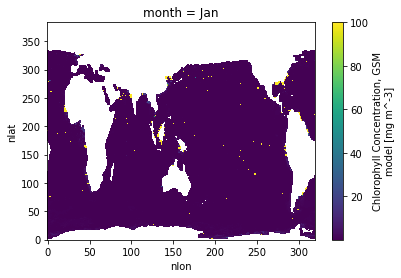

In [11]:
#plot Observational Data:
dsobs.chl_gsm.sel(month='Jan').plot();

obs data shape: (1, 12, 384, 320) model data shape: (12, 384, 320)


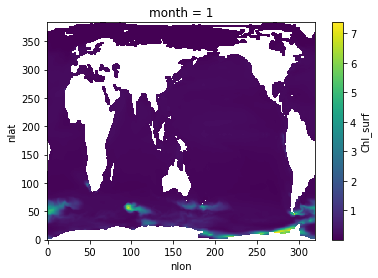

In [12]:
#plot CESM:
dsmod.Chl_surf.sel(month=1).plot();
print('obs data shape:', dsobs.chl_gsm.shape, 'model data shape:', dsmod.Chl_surf.shape)

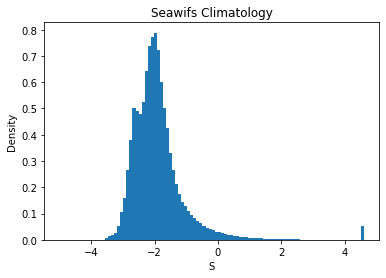

In [32]:
## Histograms of Seawifs
obs_log_trans = np.log(dsobs.chl_gsm.where(dsobs.chl_gsm>0))
plt.figure()
plt.hist(obs_log_trans.values.ravel(), 100, density=True);
plt.title('Seawifs Climatology')
plt.xlabel('S')
plt.ylabel('Density');

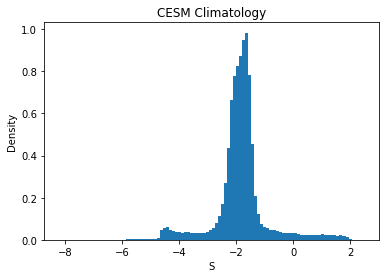

In [33]:
## Histograms of Seawifs
mod_log_trans = np.log(dsmod.Chl_surf.where(dsmod.Chl_surf>0))
plt.figure()
plt.hist(mod_log_trans.values.ravel(), 100, density=True);
plt.title('CESM Climatology')
plt.xlabel('S')
plt.ylabel('Density');

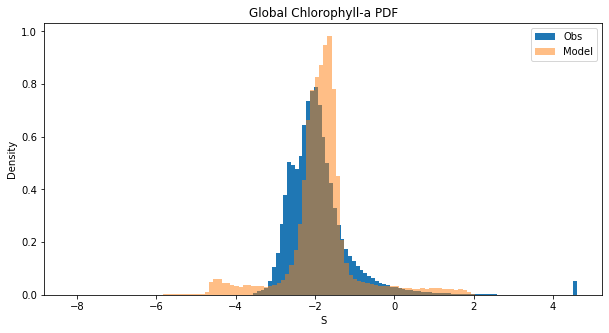

In [34]:
S_obs = obs_log_trans.values.ravel()
S_sim = mod_log_trans.values.ravel()

plt.figure(figsize=(10, 5))
plt.hist(S_obs, 100, density=True, label='Obs');
plt.hist(S_sim, 100, density=True, alpha=0.5, label='Model');
plt.xlabel('S')
plt.title('Global Chlorophyll-a PDF')
plt.ylabel('Density');
plt.legend();
#plt.savefig(save_path+'model vs obs chl compare feb 5.png')

## Make Regional PDFs

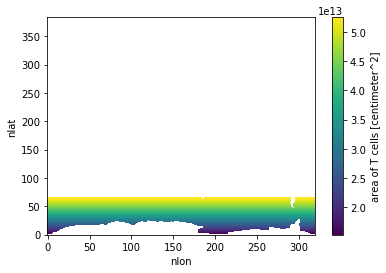

In [21]:
SO_mask = dsmod.TAREA.where((dsmod.TLAT <= -45) & (dsmod.KMT > 0))
SO_mask.plot()

/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


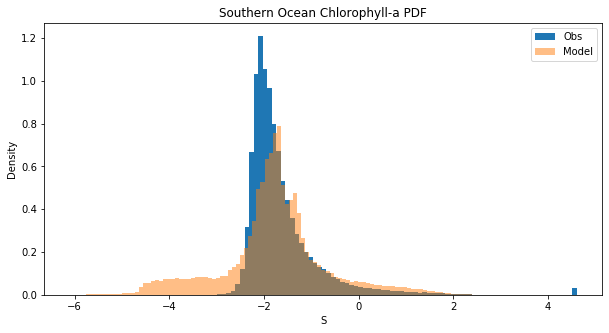

In [31]:
#Subset to Southern Ocean
ds_ob_so = dsobs.where(dsobs.TLAT <= -45)
ds_mod_so = dsmod.where(dsmod.TLAT <= -45)
#Log transform the data
mod_log_trans = np.log(ds_mod_so.Chl_surf.where(ds_mod_so.Chl_surf>0 & (ds_mod_so.TLAT <= -45)))
obs_log_trans = np.log(ds_ob_so.chl_gsm.where(ds_ob_so.chl_gsm>0 & (ds_ob_so.TLAT <= -45)))
#Make them a vector
S_obs = obs_log_trans.values.ravel()
S_sim = mod_log_trans.values.ravel()
#Plot!
plt.figure(figsize=(10, 5))
plt.hist(S_obs, 100, density=True, label='Obs');
plt.hist(S_sim, 100, density=True, alpha=0.5, label='Model');
plt.xlabel('S')
plt.title('Southern Ocean Chlorophyll-a PDF')
plt.ylabel('Density');
plt.legend();
#plt.savefig(save_path+'model vs obs chl compare feb 5.png')

Quadrants from old script:
``` #set Southern Ocean Boundary
    lat_bnds, lon_bnds = [-50, -75], [-180, 180]
    #set ZOOMed WAP SSG Bounds 
    #lat_bnds, lon_bnds = [-50, -70], [-75, -20]
    #set Lower East Bounds 
   # lat_bnds, lon_bnds = [-50, -75], [-180, -90]
    #set LRC Bounds 
    #lat_bnds, lon_bnds = [-50, -70], [115, 165]
    part1 = ds_var.sel(lat=slice(*lat_bnds), lon=slice(*lon_bnds))```

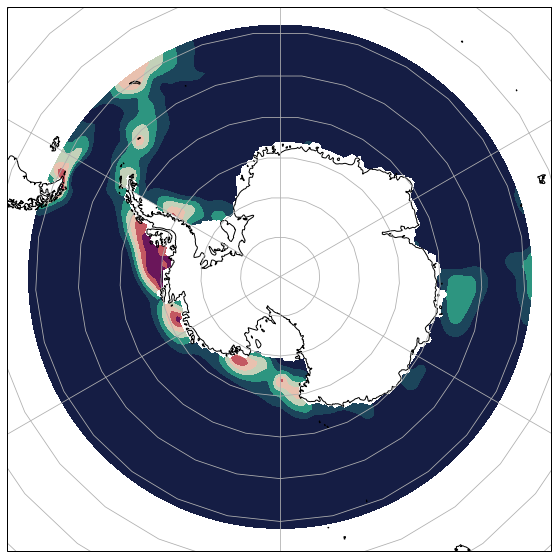

In [48]:
dsp = util.pop_add_cyclic(dsmod)

lon, lat = dsp.TLONG.isel(nlat=slice(0, 50)), dsp.TLAT.isel(nlat=slice(0, 50)) 
field = dsp.Chl_surf.isel(month=0, nlat=slice(0, 50))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
ax.set_extent([180, -180, -75,  -50], crs=ccrs.PlateCarree())

cmap = cmocean.cm.curl
#levels = np.arange(0, 30, 1)

cf = ax.contourf(lon, lat, field,
                 cmap=cmap,
                 extend='both',
                 #levels=levels,
                 transform=ccrs.PlateCarree())

ax.coastlines('50m')
ax.gridlines()

In [50]:
dsp = util.pop_add_cyclic(dsobs)

lon, lat = dsp.TLONG.isel(nlat=slice(0, 50)), dsp.TLAT.isel(nlat=slice(0, 50)) 
field = dsp.Chl_surf.isel(month='Jan', nlat=slice(0, 50))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
ax.set_extent([180, -180, -75,  -50], crs=ccrs.PlateCarree())

cmap = cmocean.cm.curl
#levels = np.arange(0, 30, 1)

cf = ax.contourf(lon, lat, field,
                 cmap=cmap,
                 extend='both',
                 #levels=levels,
                 transform=ccrs.PlateCarree())

ax.coastlines('50m')
ax.gridlines()

ValueError: different number of dimensions on data and dims: 3 vs 2